In [254]:
import math

import numpy as np
import matplotlib.pyplot as plt

In [255]:
def lagrange_basis(i, x, x_nodes):
    x_nodes_except_i = np.r_[x_nodes[:i], x_nodes[i + 1:]]
    return np.prod((x - x_nodes_except_i) / (x_nodes[i] - x_nodes_except_i))

In [256]:
def lagrange_interpolant(x, x_nodes, y_nodes):
    n = len(x_nodes)
    return np.sum(y_nodes * np.array([lagrange_basis(i, x, x_nodes) for i in range(n)]))

In [257]:
def plot_data_and_interpolant(x_nodes, f):
    y_nodes = f(x_nodes)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x_for_plotting = np.linspace(-1, 1, 200)
    ax.plot(x_nodes, f(x_nodes), 'ro', markersize=10)
    ax.plot(x_for_plotting, f(x_for_plotting), '-', color="#aaa")
    ax.plot(x_for_plotting, [lagrange_interpolant(x, x_nodes, y_nodes) for x in x_for_plotting], 'g-', linewidth=4)
    ax.grid()

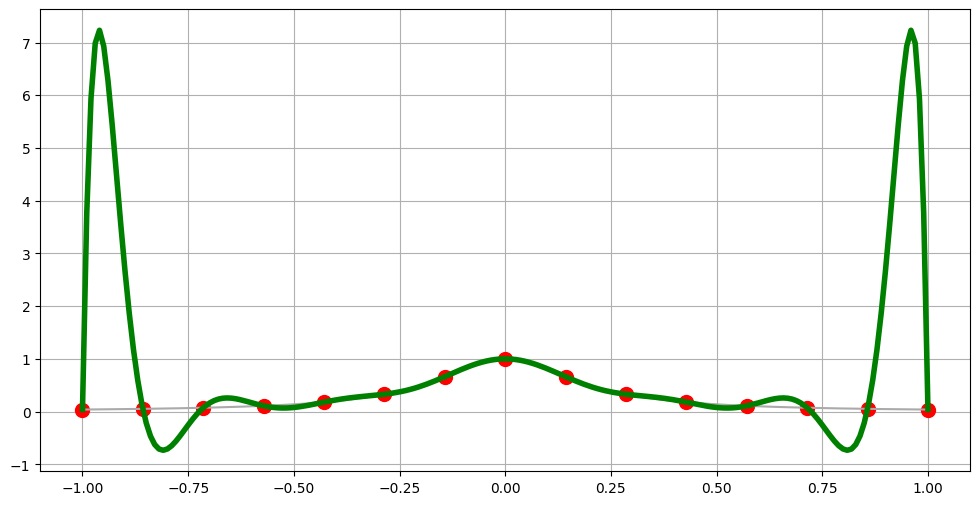

In [258]:
f = lambda x: 1. / (1. + 25 * x ** 2)
n = 15
x_equi_nodes = np.linspace(-1, 1, n)
plot_data_and_interpolant(x_equi_nodes, f)

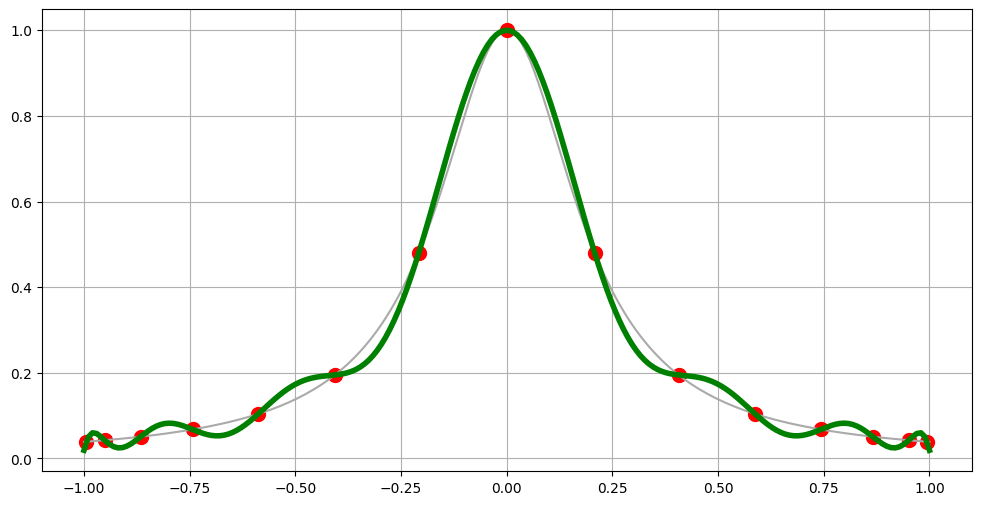

In [259]:
x_cheby_nodes = np.array([np.cos((2 * i - 1) / (2 * n) * np.pi) for i in range(1, n + 1)])
plot_data_and_interpolant(x_cheby_nodes, f)

In [260]:
def gauss(l_mat: np.matrix, r_mat):
    for j in range(len(l_mat) - 1, -1, -1):
        for i in range(len(l_mat)):
            if i == j:
                continue

            if l_mat[i, j] != 0:
                r_mat[i] -= l_mat[i, j] / l_mat[j, j] * r_mat[j]
                l_mat[i, j] = 0

    return l_mat, r_mat

In [261]:
def splain_2_interpolant(x, x_nodes, y_nodes):
    n = len(x_nodes)

    l_mat = np.matrix([
        [(1. if (j == i or j == i + 1) else 0.) for j in range(n)] for i in range(n)
    ])

    r_mat = np.array([
                         2 / (x_nodes[i + 1] - x_nodes[i]) * (y_nodes[i + 1] - y_nodes[i]) for i in range(n - 1)
                     ] + [0.])

    l_mat, r_mat = gauss(l_mat, r_mat)

    for i in range(n - 1):
        if x_nodes[i] <= x <= x_nodes[i + 1]:
            a = y_nodes[i]
            b = r_mat[i]
            c = (r_mat[i + 1] - r_mat[i]) / (2 * (x_nodes[i + 1] - x_nodes[i]))
            function = lambda x: a + b * (x - x_nodes[i]) + c * (x - x_nodes[i]) ** 2

            return function(x)



In [262]:
def plot_data_and_2_splain(x_nodes, f):
    y_nodes = f(x_nodes)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x_for_plotting = np.linspace(x_nodes[0], x_nodes[len(x_nodes) - 1], 200)
    ax.plot(x_nodes, y_nodes, 'ro', markersize=10)
    ax.plot(x_for_plotting, f(x_for_plotting), '-', color="#aaa")
    ax.plot(x_for_plotting, [splain_2_interpolant(x, x_nodes, y_nodes) for x in x_for_plotting], 'g-', linewidth=4)
    ax.grid()

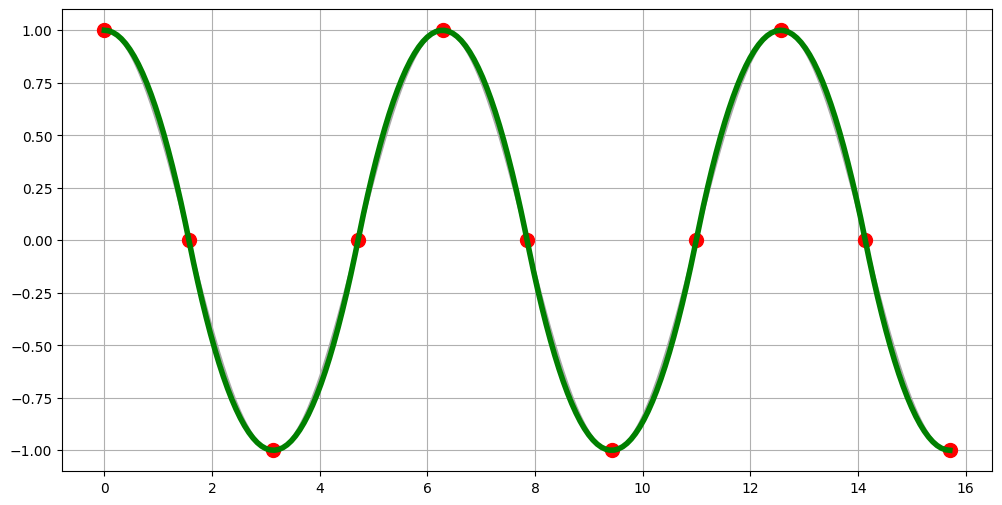

In [263]:
f = lambda x: np.cos(x)
x_sin_nodes = np.linspace(0, 5 * np.pi, 11)
plot_data_and_2_splain(x_sin_nodes, f)

In [264]:
def progonka(mat: np.matrix, vals: np.array):
    n = len(vals)

    a = [-mat[0, 1] / mat[0, 0]]
    b = [vals[0] / mat[0, 0]]

    for i in range(1, n):
        y = mat[i, i] + mat[i, i - 1] * a[-1]

        if i < n - 1:
            a.append(- mat[i, i + 1] / y)
        b.append((vals[i] - mat[i, i - 1] * b[-1]) / y)

    res = [b[-1]]
    for i in range(n - 2, -1, -1):
        res.append(a[i] * res[-1] + b[i])

    return np.array(res)[::-1]

In [265]:
def get_splain_3_interpolant(x_points, x_nodes, y_nodes):
    n = len(x_nodes) - 1

    a = y_nodes

    h = [x_nodes[i + 1] - x_nodes[i] for i in range(n)]

    mat = np.matrix(
        [([1.] + [0.] * n)] +

        [[0.] * (i - 1) +
         [h[i - 1]] + [2 * (h[i] + h[i - 1])] + [h[i]] +
         [0.] * (n - i - 1) for i in range(1, n)] +

        [([0.] * n + [1.])]
    )

    vals = np.array([0.] +
                    [3 / h[i] * (a[i + 1] - a[i]) - 3 / h[i - 1] * (a[i] - a[i - 1]) for i in
                     range(1, n)] +
                    [0.])

    c = progonka(mat, vals)

    b = []
    for i in range(n):
        b.append(1 / h[i] * (a[i + 1] - a[i]) - h[i] / 3 * (c[i + 1] + 2 * c[i]))

    d = []
    for i in range(n):
        d.append((c[i + 1] - c[i]) / (3 * h[i]))

    y_points = []
    for x in x_points:
        for i in range(n):
            if x_nodes[i] <= x <= x_nodes[i + 1]:
                y_points.append(a[i] + b[i] * (x - x_nodes[i]) + c[i] * (x - x_nodes[i]) ** 2 + d[i] * (x - x_nodes[i]) ** 3)
                break

    return y_points

In [266]:
def data_plot(x_nodes, y_nodes, method):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    ax.plot(x_nodes, y_nodes, 'ro', markersize=10)

    t_for_plotting = np.arange(0, n, 0.01)
    x_points = method(t_for_plotting, [i for i in range(len(x_nodes))], x_nodes)
    y_points = method(t_for_plotting, [i for i in range(len(y_nodes))], y_nodes)

    ax.plot(x_points, y_points, 'g-', linewidth=4)
    ax.grid()

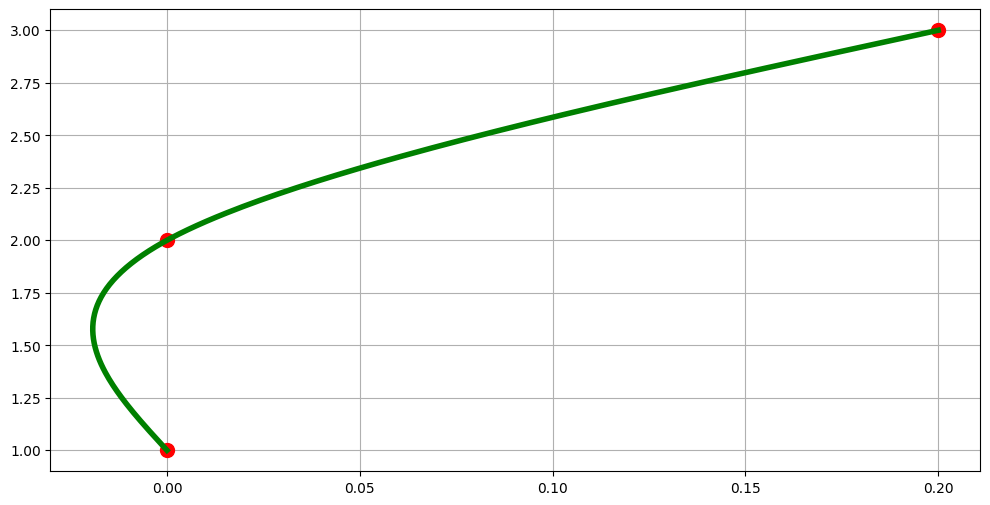

In [267]:
x_nodes = [0.0, 0.000000000000001, 0.2]
y_nodes = [1.0, 2.0, 3.0]
data_plot(x_nodes, y_nodes, splain_3_interpolant)